# Comparison with Variance-reduced Zeroth order
In this notebook, we propose some experiments in order to compare SSZD with its variance-reduced variant.

## Imports

In [1]:
import os
import numpy as np
from sszd import SSZD, SSVRZD
import matplotlib
import matplotlib.pyplot as plt
from experiments_utils.synthetic_functions import BenchmarkFunction

out_dir = "./results/variance_reduced"

os.makedirs(out_dir, exist_ok=True)

## Auxiliary functions and variables

In [2]:
class StronglyConvexFunction(BenchmarkFunction):
    
    def __init__(self, d, seed =12):
        super().__init__("StronglyConvex", d)
        self.rnd_state = np.random.RandomState(seed = seed)
        self.A = self.rnd_state.rand(d, d)
        
    def __call__(self, x, z = None):
        if z is None:
            return 1/self.d * (np.linalg.norm(self.A.dot(x))**2)
        row = self.A[z, :]
        return (np.linalg.norm(row.dot(x))**2)

In [3]:
d = 100 # dimensions
rnd_state = np.random.RandomState(seed=1212)
strong_conv_target = StronglyConvexFunction(d, seed=12)

In [4]:
import time

def execute_experiment(alg, target, budget, x, z = None, deterministic=False):
    y_fun = [target(x)]
    ctime = []
    for k in range(1, budget):
        it_time = time.time()
        x = alg.step(target, x, z)
        it_time = time.time() - it_time
        if not deterministic:
            z = rnd_state.randint(low=0, high=d)
        y_fun.append(target(x))
        ctime.append(it_time)
    ctime = np.cumsum(ctime)
    return y_fun, ctime

## Experiment with $\alpha = 1/\sqrt{k}$

In [167]:
# Parameters
A = strong_conv_target.A
w, _ = np.linalg.eigh(A.T.dot(A))

L = w[-1] / A.shape[0]
reps = 10

l = d//2

alpha = lambda k : 0.2 * l/(d * L) * 1/np.sqrt(k) #np.sqrt(k) # Step-size
alpha_det = lambda k : 0.1 * l/(d * L) #np.sqrt(k) # Step-size

h = lambda k : 1/k # Discretization parameter

y_ssvrzd_sph, ctime_ssvrzd_sph = [], []
y_sszd_sph, ctime_sszd_sph = [], []
y_szd_sph, ctime_szd_sph = [], []

sszd_sph = SSZD('spherical', d, l,  alpha, h,  dtype = np.float64, seed = 12)
szd_sph = SSZD('spherical', d, l,  alpha, h,  dtype = np.float64, seed = 12)
ssvrzd_sph = SSVRZD(5, 'spherical', d, l,  alpha, h,  dtype = np.float64, seed = 12)


for i in range(reps):
    x = np.asarray([10.0 for _ in range(d)])
    z = 0
    budget = 500 #5000
    print("[--] Episode: {}/{}".format(i, reps))
    sszd_y, sszd_time = execute_experiment(sszd_sph, strong_conv_target, budget, x, z)
    szd_y, szd_time = execute_experiment(szd_sph, strong_conv_target, budget, x, None, True)
    vr_y, vr_time = execute_experiment(ssvrzd_sph, strong_conv_target, budget, x, z)
    
    y_ssvrzd_sph.append(vr_y)
    ctime_ssvrzd_sph.append(vr_time)
    y_sszd_sph.append(sszd_y)
    ctime_sszd_sph.append(sszd_time)
    y_szd_sph.append(szd_y)
    ctime_szd_sph.append(szd_time)
    sszd_sph.reset()
    szd_sph.reset()
    ssvrzd_sph.reset()
print("[--] Done!")

[--] Episode: 0/10
[--] Episode: 1/10
[--] Episode: 2/10
[--] Episode: 3/10
[--] Episode: 4/10
[--] Episode: 5/10
[--] Episode: 6/10
[--] Episode: 7/10
[--] Episode: 8/10
[--] Episode: 9/10
[--] Done!


In [168]:
# Collect y results
sph_mean, sph_std = np.mean(y_sszd_sph, axis=0), np.std(y_sszd_sph, axis=0)
sph_det_mean, sph_det_std = np.mean(y_szd_sph, axis=0), np.std(y_szd_sph, axis=0)
sph_vr_mean, sph_vr_std = np.mean(y_ssvrzd_sph, axis=0), np.std(y_ssvrzd_sph, axis=0)

# Collect y results
sph_mean_tm, sph_std_tm = np.mean(ctime_sszd_sph, axis=0), np.std(ctime_sszd_sph, axis=0)
sph_det_mean_tm, sph_det_std_tm = np.mean(ctime_szd_sph, axis=0), np.std(ctime_szd_sph, axis=0)
sph_vr_mean_tm, sph_vr_std_tm = np.mean(ctime_ssvrzd_sph, axis=0), np.std(ctime_ssvrzd_sph, axis=0)



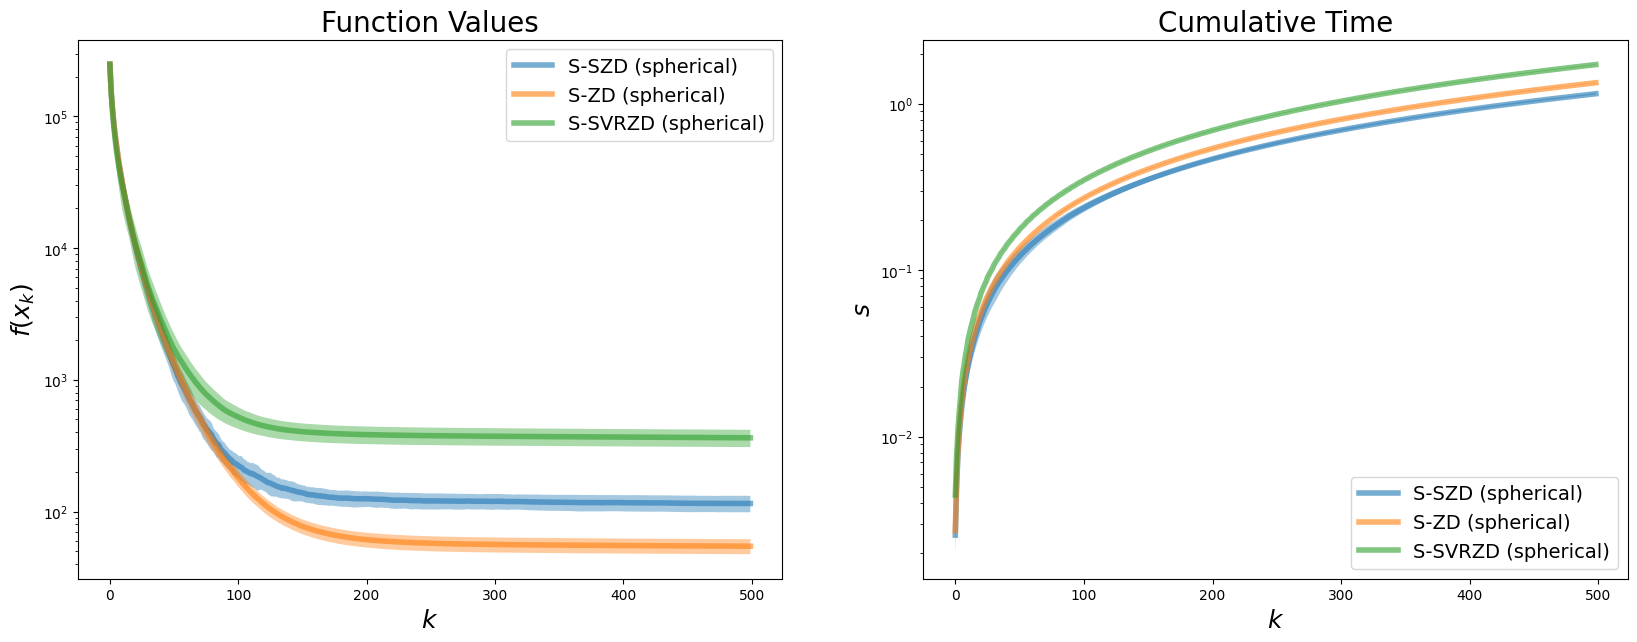

In [169]:

def plot_mean_std(ax, mean, std, label):
    ax.plot(range(len(mean)),   mean, '-', lw=4, alpha=0.6, label=label)
    ax.fill_between(range(len(mean)),  mean + std, mean - std, alpha=0.4)
   

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1.set_title("Function Values", fontsize=20)
ax2.set_title("Cumulative Time", fontsize=20)

plot_mean_std(ax1, sph_mean, sph_std, label="S-SZD (spherical)")
plot_mean_std(ax1, sph_det_mean, sph_det_std, label="S-ZD (spherical)")
plot_mean_std(ax1, sph_vr_mean, sph_vr_std, label="S-SVRZD (spherical)")


plot_mean_std(ax2, sph_mean_tm, sph_std_tm, label="S-SZD (spherical)")
plot_mean_std(ax2, sph_det_mean_tm, sph_det_std_tm, label="S-ZD (spherical)")
plot_mean_std(ax2, sph_vr_mean_tm, sph_vr_std_tm, label="S-SVRZD (spherical)")




ax1.set_xlabel("$k$", fontsize=18)
ax1.set_ylabel("$f(x_k)$", fontsize=18)
ax2.set_xlabel("$k$", fontsize=18)
ax2.set_ylabel("$s$", fontsize=18)

ax1.legend(loc="upper right", fontsize=14)
ax1.set_yscale("log")
ax2.legend(loc="lower right", fontsize=14)
ax2.set_yscale("log")


In [162]:
def change_num_iters(num_iter, reps, budget):
    ssvrzd_sph = SSVRZD(num_iter, 'spherical', d, l,  alpha, h,  dtype = np.float64, seed = it)

    y_values = np.zeros((reps, budget))
    ctime = np.zeros((reps, budget-1))
    
    for i in range(reps):
        x = np.asarray([10.0 for _ in range(d)])
        z = 0
        print("[NI={}] Episode: {}/{}".format(num_iter, i, reps))
        vr_y, vr_time = execute_experiment(ssvrzd_sph, strong_conv_target, budget, x, z)
        y_values[i] = vr_y
        ctime[i] = vr_time
    ctime = np.cumsum(ctime, axis=1)
    return y_values.mean(axis=0), y_values.std(axis=0), ctime.mean(axis=0), ctime.std(axis=0)

reps = 10
budget = 500

iters = [1, 5, 10, 20]    

results = []
for it in iters:
    results.append(change_num_iters(it, reps, budget))

    
    

[NI=1] Episode: 0/10
[NI=1] Episode: 1/10
[NI=1] Episode: 2/10
[NI=1] Episode: 3/10
[NI=1] Episode: 4/10
[NI=1] Episode: 5/10
[NI=1] Episode: 6/10
[NI=1] Episode: 7/10
[NI=1] Episode: 8/10
[NI=1] Episode: 9/10
[NI=5] Episode: 0/10
[NI=5] Episode: 1/10
[NI=5] Episode: 2/10
[NI=5] Episode: 3/10
[NI=5] Episode: 4/10
[NI=5] Episode: 5/10
[NI=5] Episode: 6/10
[NI=5] Episode: 7/10
[NI=5] Episode: 8/10
[NI=5] Episode: 9/10
[NI=10] Episode: 0/10
[NI=10] Episode: 1/10
[NI=10] Episode: 2/10
[NI=10] Episode: 3/10
[NI=10] Episode: 4/10
[NI=10] Episode: 5/10
[NI=10] Episode: 6/10
[NI=10] Episode: 7/10
[NI=10] Episode: 8/10
[NI=10] Episode: 9/10
[NI=20] Episode: 0/10
[NI=20] Episode: 1/10
[NI=20] Episode: 2/10
[NI=20] Episode: 3/10
[NI=20] Episode: 4/10
[NI=20] Episode: 5/10
[NI=20] Episode: 6/10
[NI=20] Episode: 7/10
[NI=20] Episode: 8/10
[NI=20] Episode: 9/10


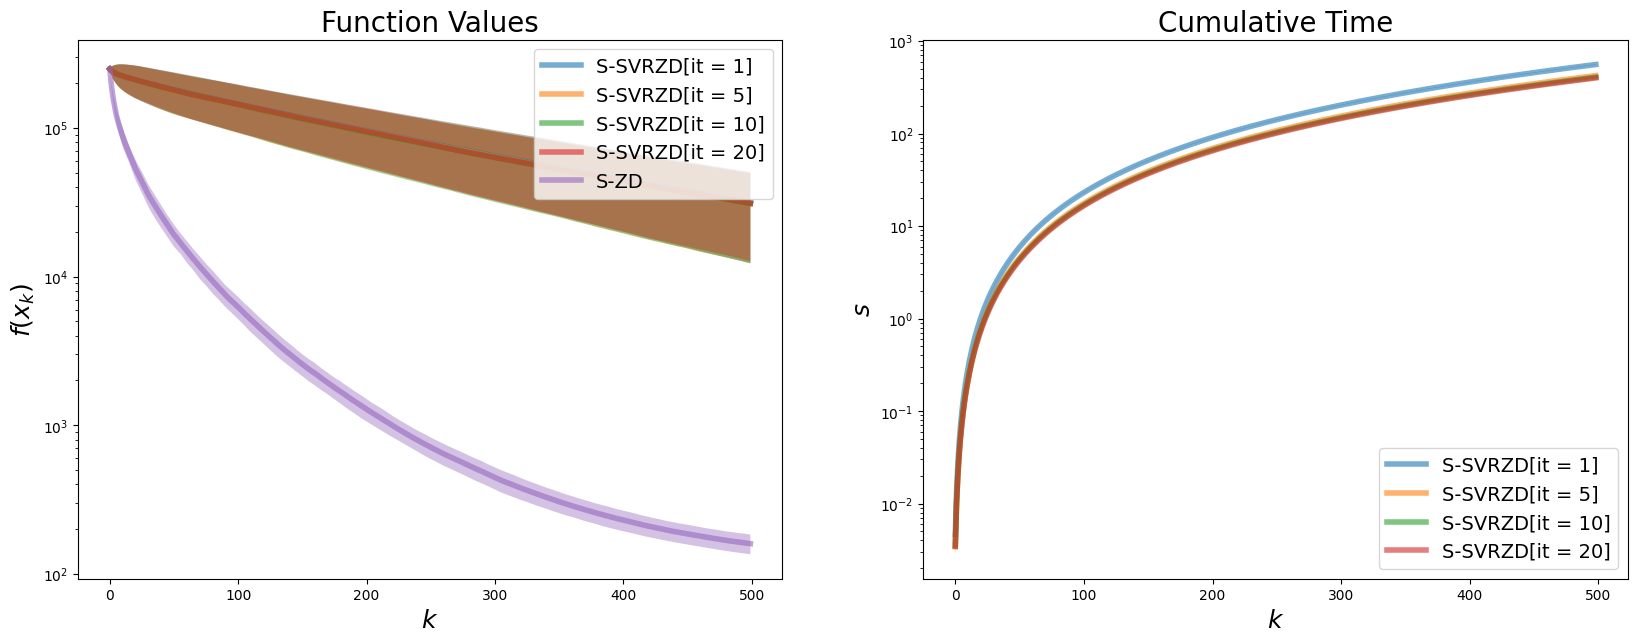

In [163]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1.set_title("Function Values", fontsize=20)
ax2.set_title("Cumulative Time", fontsize=20)

for (it, ris) in zip(iters, results):
    y_mean, y_std, tm_mean, tm_std = ris
    
    plot_mean_std(ax1, y_mean , y_std, label="S-SVRZD[it = {}]".format(it))
    plot_mean_std(ax2, tm_mean, tm_std, label="S-SVRZD[it = {}]".format(it))

plot_mean_std(ax1, sph_vr_mean, sph_vr_std, label="S-ZD")



ax1.set_xlabel("$k$", fontsize=18)
ax1.set_ylabel("$f(x_k)$", fontsize=18)
ax2.set_xlabel("$k$", fontsize=18)
ax2.set_ylabel("$s$", fontsize=18)

ax1.legend(loc="upper right", fontsize=14)
ax1.set_yscale("log")
ax2.legend(loc="lower right", fontsize=14)
ax2.set_yscale("log")
